In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62
from src.models import Net, ConvBlock, LinearBlock
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from torch import optim, nn

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold
# Load data
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
dataset_5fold = pd.read_csv('../data/cedar_neoepitopes_partition_5fold.csv')
dataset_10fold = pipeline_stratified_kfold('../out/cedar_peps_hobohm_0.925.pep', cedar, k=10, shuffle=True)
sample = dataset_10fold.sample(10)[['Peptide', 'HLA', 'trueHLA_EL_rank', 'agg_label', 'len']]
# other data/stuff
prime = pd.read_excel('../data/other/PRIME_dataset.xlsx', skiprows=2, comment='#')
prime_random=prime.query('StudyOrigin == "Random"')
ics_kl = pkl_load('../output/ics_kl.pkl')
ics_shannon = pkl_load('../output/ics_shannon.pkl')
ics_none = None

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


# dataset checks

In [2]:
mixed=pd.read_csv('../data/script_traindata/cedar_hp_mixed_10fold.csv')

In [3]:
ct=mixed.groupby('agg_label')['Peptide'].count()
ct[1]/ct[0]

0.10072497300632423

# Peptide values

In [5]:
import peptides
from datetime import datetime as dt
from src.data_processing import get_aa_properties

start = dt.now()
vals = get_aa_properties(dataset_10fold)[0][['Peptide', 'HLA', 'agg_label', 'fold','len', 'trueHLA_EL_rank',
 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65',
 'hydrophobicity', 'isoelectric_point', 'PD2', 'VHSE1', 'VHSE2', 'VHSE3',
 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']]
end = dt.now()
elapsed = divmod((end-start).seconds, 60)
print(f'Time elapsed: {elapsed[0]}m {elapsed[1]}s or {(end-start).microseconds} ms')

Time elapsed: 0m 2s or 899087 ms


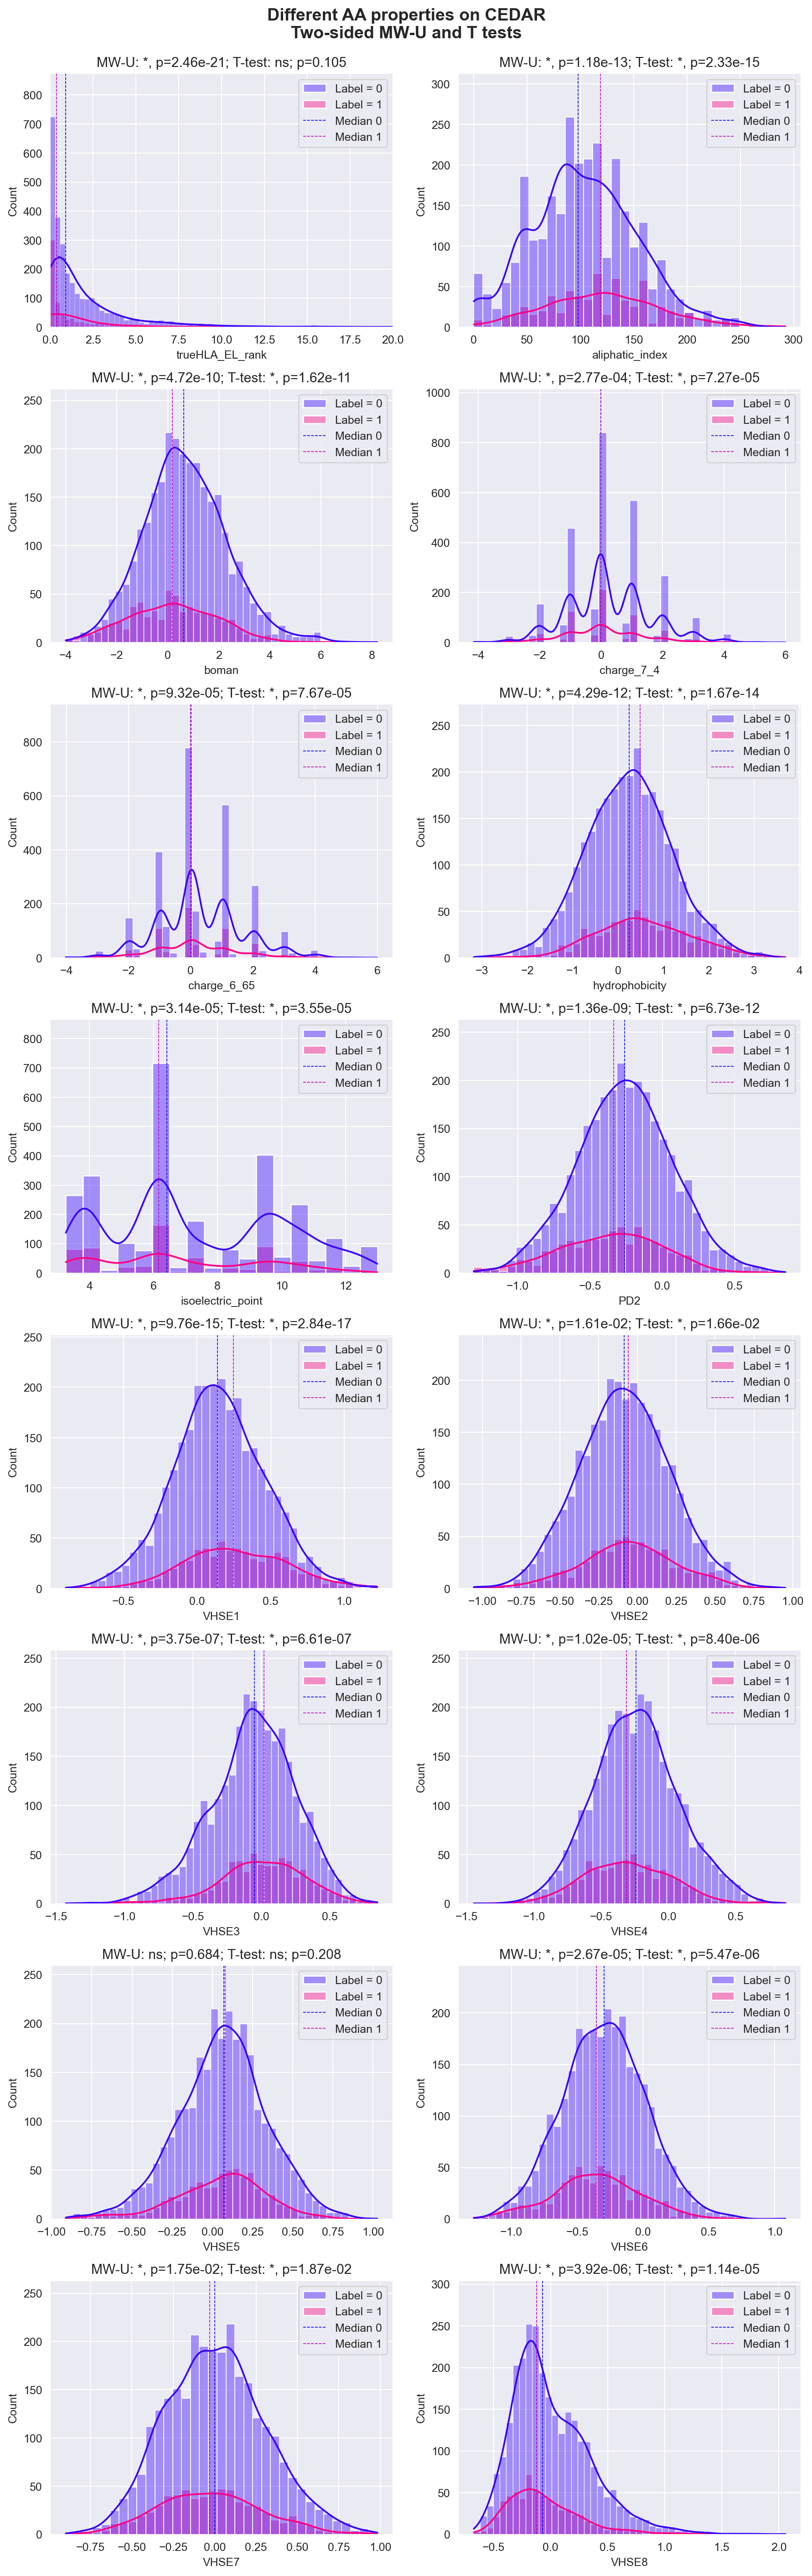

In [6]:
# Checking distributions 
from scipy.stats import mannwhitneyu, ttest_ind
pal = sns.color_palette('hsv', n_colors = 13)
sns.set_palette([pal[-4], pal[-1]])
f,a = plt.subplots(8,2, figsize = (10, 32))
ax = a.ravel()

label_column = ['agg_label']
for i,key in enumerate(['trueHLA_EL_rank', 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65', 'hydrophobicity', 
                        'isoelectric_point', 'PD2',  'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']):
    gb=vals.groupby('agg_label')[key].agg(['mean', 'median'])
    med_0 = gb.loc[0,'median']
    med_1 = gb.loc[1, 'median']
    sns.histplot(data = vals, x = key, hue='agg_label', alpha = 0.4, kde=True, ax=ax[i], legend=True, hue_order=[0,1])
    # Reset max ylim
    upper = ax[i].get_ylim()[1]
    ax[i].set_ylim([0, upper* 1.15])
    
    # Mann Whitney U test
    pos, neg = vals.query('agg_label==1')[key].values, vals.query('agg_label==0')[key].values
    _, pval_mw = mannwhitneyu(pos, neg)
    _, pval_t = ttest_ind(pos,neg)
    sig_mw = f'ns; p={pval_mw:.3f}' if pval_mw>0.05 else f'*, p={pval_mw:.2e}'
    sig_t = f'ns; p={pval_t:.3f}' if pval_t>0.05 else f'*, p={pval_t:.2e}'
    ax[i].set_title(f'MW-U: {sig_mw}; T-test: {sig_t}')
    # Reset ax if HLA rank
    if key == 'trueHLA_EL_rank':
        ax[i].set_xlim([0,20])
        
    # Drawing axvlines
    ax[i].axvline(x=med_0, label = 'Median 0', ls = '--', lw = '.65', color='b' )
    ax[i].axvline(x=med_1, label = 'Median 1', ls = '--', lw = '.65', color='m')
    # Get the fucking rectangles from sns plots
    legend = ax[i].get_legend()
    handles = legend.legendHandles
    # Combine to the fucking lines from plt/ax plots
    handles.extend(ax[i].get_legend_handles_labels()[0])
    # Set the labels manually like a dog
    labels = ["Label = 0", "Label = 1", "Median 0", "Median 1"]
    # Reset the legend manually like a dog
    ax[i].legend(handles = handles, labels = labels)
f.suptitle('Different AA properties on CEDAR\nTwo-sided MW-U and T tests', fontweight= 'semibold',fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.955)

# Kwargs stuff

In [7]:
from src.data_processing import BL62FREQ_VALUES, BL62_VALUES, batch_compute_frequency, encode_batch_weighted, encode_batch, get_array_dataset, standardize
# pass encoding_kwarg dict in nested_kcv_train fct, and pass it as **kwargs in the get_array_dataset call within the function

kwargs = {'max_len':12,
          'encoding':'blosum',
          'blosum_matrix':BL62FREQ_VALUES,
          'mask':False,
          'add_rank':True,
          'add_aaprop':True}
x,y = get_array_dataset(sample, ics_shannon, **kwargs)
x1,y1 = get_array_dataset(sample, ics_shannon, encoding='blosum', blosum_matrix=BL62FREQ_VALUES, add_aaprop=False, add_rank=False)
xv,yv = get_array_dataset(dataset_10fold.sample(5), ics_shannon, **kwargs)

[0.03340296 0.04055942 0.02793318 0.05290324 0.06913677 0.02849403
 0.02837021 0.01878456 0.02902355 0.07032844 0.06630655 0.02868181
 0.04992964 0.04413658 0.02041746 0.04223172 0.0366164  0.02856114
 0.07927969 0.06382663] (10, 20)
(10, 1)
(10, 21)
(10, 15)
(10, 36)
[0.03340296 0.04055942 0.02793318 0.05290324 0.06913677 0.02849403
 0.02837021 0.01878456 0.02902355 0.07032844 0.06630655 0.02868181
 0.04992964 0.04413658 0.02041746 0.04223172 0.0366164  0.02856114
 0.07927969 0.06382663] (10, 20)
[0.03510252 0.07135413 0.03094236 0.03000783 0.02666305 0.06338208
 0.05942894 0.02006548 0.02966722 0.07138687 0.08212788 0.06493263
 0.05925639 0.03469293 0.02507968 0.03681841 0.05689224 0.02263371
 0.03008006 0.06200534] (5, 20)
(5, 1)
(5, 21)
(5, 15)
(5, 36)


# Wrapper with encoding kwargs stuff

In [ ]:
md = LinearBlock(1,2)
# Use this to do the switch in train wrapper
issubclass(md.__class__, nn.Module)

In [ ]:
# Wrapper stuff : 
def kcv_wrapper(train_dataset,dataset_name, model_type, weighting, weighting_name, add_rank):
    """
    TODO: HERE BASICALLY MERGE ALL THE DIFFERENT ENCODING ARGS INTO A DICT, AND PASS IT AS ENCODINGKWARGS TO NESTED_KCV_TRAIN!
    """
    # dataset_name = f'{train_dataset=}'.split('=')[0]
    # print(dataset_name)
    ic_name = f'{weighting=}'.split('=')[0]
    rank_name = f'EL_{add_rank}'
    model_name = model_type.__name__

    if model_name == 'LinearBlock':
        results = np.random.randint(100,200, size=[5]) # HERE REPLACE WITH RESULTS = KCV SOME SHIT
    else:
        results = np.random.randint(0,5, size=[5])
    outname = model_name+rank_name+weighting_name+dataset_name
    return outname, results

results = []
# Maybe keep the kwargs as loop, and parallelize models & datasets instead?
# Not the most efficient but more readable / easy to write in terms of arguments because of 
for train_dataset, dataset_name in zip([dataset_5fold, dataset_10fold], ['cedar', 'cedar_hp']):
    for model in [RandomForestClassifier, XGBClassifier, LogisticRegression, LinearBlock]:
        kcv_wrapper_ = partial(kcv_wrapper, train_dataset = train_dataset, dataset_name = dataset_name, model_type = model)
        output = Parallel(n_jobs=4)(delayed(kcv_wrapper_)(weighting=weighting, weighting_name=weighting_name, add_rank=add_rank) for (weighting, weighting_name), add_rank in \
                                    product(zip([ics_shannon, ics_kl, ics_none], ['shannon','kl','none']), [True, False]))
        results.extend(output)
        

In [13]:
d = {'a':1, 'b':2, 'c':3}
name = '_'.join([f'{k}{v}' for k,v in d.items() if k!='b'])
name

'a1_c3'

In [11]:
for encoding, bl in zip(['onehot', 'blosum', 'blosum'], [None, BL62FREQ_VALUES, BL62_VALUES]):
    if bl is not None:
        print(encoding, bl['A'].dtype)
    else: 
        print(encoding)

onehot
blosum float64
blosum int64


In [24]:
encoding_kwargs = {'max_len':12,
                   'encoding':1,
                   'blosum_matrix':2,
                   'mask': 3,
                   'add_rank': 4,
                   'add_aaprop': 5,
                   'remove_pep':6,
                   'standardize': 7}
outname = {'model':'rf'}
# Save the parameter name as a massive string to tag the output.
outname.update({k:v for k,v in encoding_kwargs.items() if k!='blosum_matrix'})
'_'.join([f"{k.replace('add_','')}{v}" for k,v in outname.items()])

'modelrf_max_len12_encoding1_mask3_rank4_aaprop5_remove_pep6_standardize7'

In [29]:
import xgboost
xgboost.XGBClassifier().__class__.__name__

'XGBClassifier'

# DEFINE LOOPS AND COMBINATIONS

In [30]:
from itertools import product

In [ ]:
# ENCODINGS
encoding, blosum_matrix in zip(['onehot', 'blosum', 'blosum'], [None, BL62FREQ_VALUES, BL62_VALUES])
# Weight & masking ; Triple zip because it's not really conditional products
ics_dict, ics_name, mask in zip([ics_shannon, ics_kl, ics_none, ics_shannon], 
                                ['Shannon', 'KL', 'None', 'Mask'], 
                                [False, False, False, True])
# Add rank/aa prop and remove pep?# Add Rank, Add aa prop, Remove Pep
# Using conditional products ; BUT if I just flatten it to a 6 list combination then I can parallelize easily
for rank, prop in product([True, False],[True, False]):
    remove_pep = [False, True] if (prop) else [False]
    for remove_pep in remove_pep:
        print('rank', rank, '\tprop', prop, '\tremove_pep', remove_pep)
# So here instead for ADD_RANK, ADD_AAPROP, REMOVE_PEP: 
print('\n')
for add_rank, add_aaprop, remove_pep in zip([True, True, True, False, False, False],
                                            [True, True, False, True, True, False],
                                            [False, True, False, False, True, False]):
    print('rank', rank, '\tprop', prop, '\tremove_pep', remove_pep)
# Not sure it's more readable than before though...

In [59]:
enc_blosum = zip(['onehot', 'blosum', 'blosum'], [None, 6, 7])

ics_mask = zip([1, 2, 3, 4], 
               ['Shannon', 'KL', 'None', 'Mask'], 
               [False, False, False, True])

rank_prop_remove = zip([True, True, True, False, False, False],
                       [True, True, False, True, True, False],
                       [False, True, False, False, True, False])
std = [True, False]
i=0
for a,b in product(product(product(std, rank_prop_remove), ics_mask), enc_blosum):
    i+=1
print(i)

144


In [66]:
import random
np.random.randint(0,10, 

In [75]:
import random
sets = np.random.choice(dataset_10fold.fold.unique(), 2)
dataset_10fold.query('fold in @sets')

,Peptide,HLA,trueHLA_EL_rank,agg_label,fold,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count
7,AALLQVTLLL,HLA-A02:01,1.1841,0,2,1.1018,0.5721,27198675,ALLQVTLLL,AALLQVTLLL,Negative,10,0.0,1.1841,0.1910,HLA-A02:01,Negative,1
12,AAQSVIKAL,HLA-B07:02,0.7826,0,2,0.3044,0.5934,27198675,AAQSVIKAL,AAQSVIKAL,Negative,9,0.0,0.0634,0.7871,HLA-C03:03,Negative,1
15,AAYQRLTSEK,HLA-A11:01,0.2914,0,2,0.5502,0.5739,24323902,AAYQRLTSK,AAYQRLTSEK,Negative,10,0.0,0.1906,0.4778,HLA-A30:01,Negative,1
17,AEETPPFSNY,HLA-B44:03,0.0334,0,1,0.1229,0.5609,30556813,AETPPFSNY,AEETPPFSNY,Negative,10,0.0,0.0334,0.9549,HLA-B44:03,Negative,1
23,AEVDQDGVVM,HLA-B44:03,0.3688,0,2,0.1557,0.6350,"34244308,34244308",AEVDQGVVM,AEVDQDGVVM,Negative,10,0.0,0.0935,0.9005,HLA-B40:01,"Negative,Negative",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3525,YTRDQIMTI,HLA-A02:01,1.4211,0,2,0.0497,0.6269,27198675,YTRDQIMTI,YTRDQIMTI,Negative,9,0.0,0.0172,0.8653,HLA-C15:02,Negative,1
3549,YVTAMDIFV,HLA-A02:01,1.2052,1,2,0.0691,0.7197,30418433,YVTAMDIFV,YVTAMDIFV,Positive,9,1.0,0.3990,0.3214,HLA-A69:01,Positive_all,1
3555,YWSLLSHPL,HLA-A24:02,0.9633,0,2,0.0571,0.7893,27198675,YWSLLSHPL,YWSLLSHPL,Negative,9,0.0,0.2854,0.4564,HLA-C14:02,Negative,1
3562,YYPPSQIAQL,HLA-A24:02,0.0566,1,2,0.0780,0.7614,26048577,YYPPSQIAL,YYPPSQIAQL,Positive,10,1.0,0.0418,0.8745,HLA-C14:02,Positive_all,1


In [61]:
a = range(5)
b = range(10)
ls = [5,10]
for l in ls:
    print(int(0.2*l))
    print(list(range(int(0.2*l))))
    

1
[0]
2
[0, 1]


[autoreload of src.train_eval failed: Traceback (most recent call last):
  File "C:\Users\richi\anaconda3\envs\phd\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\richi\anaconda3\envs\phd\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "C:\Users\richi\anaconda3\envs\phd\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\richi\Documents\ADMIN\unixdir\code\cedar\src\train_eval.py", line 402
    test = dataframe.query('fold in )
          

standardize in True, False ? 

So just mega product of each groups of conditions; 

```
product(zip(encoding/Blosum), zip(ics_dict, ics_name,mask), zip(add_rank, add_aaprop, remove_pep), [std_true, std_false])
```

In [47]:
# Add rank/aa prop and remove pep?# Add Rank, Add aa prop, Remove Pep
# Using conditional products ; BUT if I just flatten it to a 6 list combination then I can parallelize easily
for rank, prop in product([True, False],[True, False]):
    remove_pep = [False, True] if (prop) else [False]
    for remove_pep in remove_pep:
        print('rank', rank, '\tprop', prop, '\tremove_pep', remove_pep)
# So here instead for ADD_RANK, ADD_AAPROP, REMOVE_PEP: 
print('\n')
for add_rank, add_aaprop, remove_pep in zip([True, True, True, False, False, False],
                                            [True, True, False, True, True, False],
                                            [False, True, False, False, True, False]):
    print('rank', add_rank, '\tprop', add_aaprop, '\tremove_pep', remove_pep)
# Not sure it's more readable than before though...

rank True 	prop True 	remove_pep False
rank True 	prop True 	remove_pep True
rank True 	prop False 	remove_pep False
rank False 	prop True 	remove_pep False
rank False 	prop True 	remove_pep True
rank False 	prop False 	remove_pep False


rank True 	prop True 	remove_pep False
rank True 	prop True 	remove_pep True
rank True 	prop False 	remove_pep False
rank False 	prop True 	remove_pep False
rank False 	prop True 	remove_pep True
rank False 	prop False 	remove_pep False
